In [15]:
library(vegan)
library(repr)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# sample subset
env_data_file = "../otu_data/WaterQualityData/matched_cleaned_data/all_mdata_with_habitat.txt"
select_samples <- rownames(read.delim(env_data_file, row.names=1))

# rarefied otu table
tsv.data <- read.delim("../otu_data/dispersal_selection_data/final_rarefied_table.tsv", row.names=1)
print(dim(tsv.data))

# subset 
tsv.data = tsv.data[select_samples, ]
print(dim(tsv.data))

# Remove zeros columns & rows
tsv.data =  tsv.data[rowSums(tsv.data) > 0, colSums(tsv.data) > 0]
print(dim(tsv.data))

[1]  362 1561
[1]  290 1561
[1]  290 1558


In [3]:
# read in phylo dist mat
phydf_full <- read.delim("../otu_data/dispersal_selection_data/not_full_tree_distances.tsv", row.names=1)

# subset it to observed abundances and convert to matrix
phydf = phydf_full[ colnames(tsv.data), colnames(tsv.data) ]
phydist = as.matrix(phydf)

print(dim(phydf))

[1] 1558 1558


In [4]:
# create simulated community
sim.tsv <- permatswap(tsv.data, "quasiswap", times=10)$perm[[5]]

In [5]:
exp.eco.dist = vegdist(t(tsv.data), method='bray')
exp.comm.dist = as.matrix(exp.eco.dist)

sim.eco.dist = vegdist(t(sim.tsv), method="bray")
sim.comm.dist = as.matrix(sim.eco.dist)

print(c(dim(exp.comm.dist), dim(sim.comm.dist)))

[1] 1558 1558 1558 1558


In [8]:
taxa_file = "../otu_data/dada2_outputs/taxa_table_with_OTUs.txt"
pre_taxa_df = read.delim(taxa_file, row.names=1)
pre_taxa_df[pre_taxa_df==""] <- NA

# Fix species
spc_df = pre_taxa_df[!is.na(pre_taxa_df[,'Species']),]
non_sp_df = pre_taxa_df[is.na(pre_taxa_df[,'Species']),]
spc_df <- within(spc_df, Species <- paste(Genus, Species, sep=" "))
taxa_df1 = rbind(spc_df, non_sp_df)[rownames(pre_taxa_df),]

#Fix genus
spc_df = taxa_df1[!is.na(taxa_df1[,'Genus']),]
non_sp_df = taxa_df1[is.na(taxa_df1[,'Genus']),]
spc_df <- within(spc_df, Genus <- paste(Family, Genus, sep=" "))
taxa_df2 = rbind(spc_df, non_sp_df)[rownames(taxa_df1),]

#Fix family
spc_df = taxa_df2[!is.na(taxa_df2[,'Family']),]
non_sp_df = taxa_df2[is.na(taxa_df2[,'Family']),]
spc_df <- within(spc_df, Family <- paste(Class, Family, sep=" "))
taxa_df3 = rbind(spc_df, non_sp_df)[rownames(taxa_df2),]

#Fix Class
spc_df = taxa_df3[!is.na(taxa_df3[,'Class']),]
non_sp_df = taxa_df3[is.na(taxa_df3[,'Class']),]
spc_df <- within(spc_df, Class <- paste(Order, Class, sep=" "))
taxa_df4 = rbind(spc_df, non_sp_df)[rownames(taxa_df3),]

#Fix Order
spc_df = taxa_df4[!is.na(taxa_df4[,'Order']),]
non_sp_df = taxa_df4[is.na(taxa_df4[,'Order']),]
spc_df <- within(spc_df, Order <- paste(Phylum, Order, sep=" "))
taxa_df5 = rbind(spc_df, non_sp_df)[rownames(taxa_df4),]

#Fix Phylum
spc_df = taxa_df5[!is.na(taxa_df5[,'Phylum']),]
non_sp_df = taxa_df5[is.na(taxa_df5[,'Phylum']),]
spc_df <- within(spc_df, Phylum <- paste(Kingdom, Phylum, sep=" "))
taxa_df = rbind(spc_df, non_sp_df)[rownames(taxa_df5),]

taxa_df = taxa_df[colnames(phydf_full), ]
print(apply(taxa_df, MARGIN=2, FUN=function(x) length(unique(x))))

Kingdom  Phylum   Class   Order  Family   Genus Species 
      4      33     173     151     218     345      72 


In [22]:
level_medians = list()
dist_by_level = list()
taxa_levels = colnames(taxa_df)
for (a_level in taxa_levels){
    print(a_level)
    sub_taxa = taxa_df[!is.na(taxa_df[,a_level]),]
    sub_taxa2 = sub_taxa[sub_taxa[,a_level] %in% names(which(table(sub_taxa[,a_level]) > 1)), ]
    print(c(dim(sub_taxa)[1], 'rows'))
    avail_types = unique(sub_taxa2[,a_level])
    print(c(length(avail_types), 'appear >1 times'))
    dist_by_level[[a_level]] = vector(length=length(avail_types))
    for (t_i in 1:length(avail_types)){
        type_i = avail_types[t_i]
        otus_i = rownames(sub_taxa2[which(sub_taxa2[,a_level] == type_i),])
        sub_dist = phydf_full[otus_i, otus_i]
        med_val = median(as.dist(sub_dist))
        dist_by_level[[a_level]][t_i] = med_val
    }
    names(dist_by_level[[a_level]]) <- avail_types
    level_medians[[a_level]] = median(dist_by_level[[a_level]])
}
print(unlist(level_medians))
print(max(phydf_full))


[1] "Kingdom"
[1] "1907" "rows"
[1] "3"               "appear >1 times"
[1] "Phylum"
[1] "1886" "rows"
[1] "28"              "appear >1 times"
[1] "Class"
[1] "1843" "rows"
[1] "133"             "appear >1 times"
[1] "Order"
[1] "1730" "rows"
[1] "121"             "appear >1 times"
[1] "Family"
[1] "1402" "rows"
[1] "154"             "appear >1 times"
[1] "Genus"
[1] "972"  "rows"
[1] "164"             "appear >1 times"
[1] "Species"
[1] "72"   "rows"
[1] "1"               "appear >1 times"
   Kingdom     Phylum      Class      Order     Family      Genus    Species 
0.71706300 0.23280650 0.12400850 0.11917900 0.08159725 0.03196650 0.02532600 
[1] 4.140261


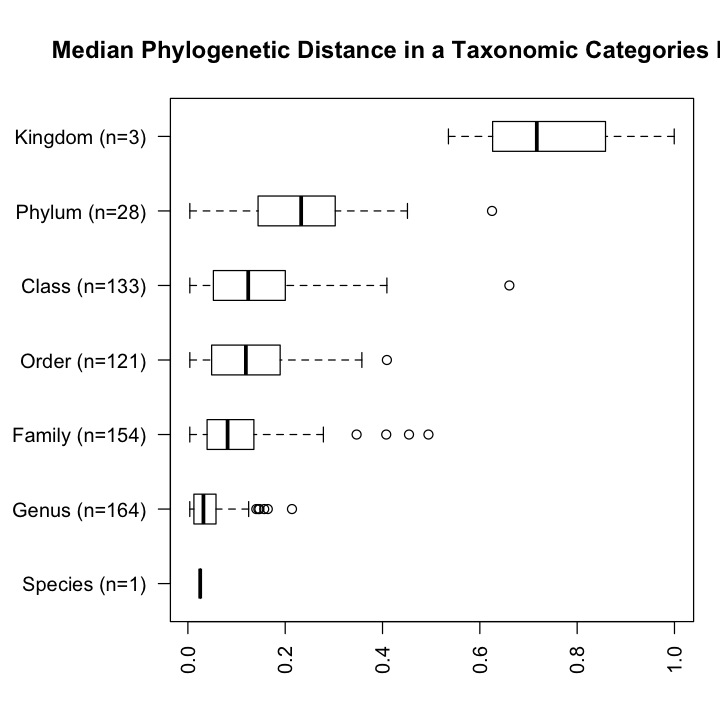

In [47]:
options(repr.plot.width=6, repr.plot.height=6)
par(mar=c(4,7,4,1)+.1)

boxplot(dist_by_level$Species, dist_by_level$Genus, dist_by_level$Family, 
        dist_by_level$Order, dist_by_level$Class, dist_by_level$Phylum,
        dist_by_level$Kingdom,
        main = "Median Phylogenetic Distance in a Taxonomic Categories by Level",
    at = 0:6*2,
    names = c("Species (n=1)", "Genus (n=164)", "Family (n=154)", 'Order (n=121)', 'Class (n=133)',
              "Phylum (n=28)", 'Kingdom (n=3)'),
    las = 2,
    horizontal = TRUE
)

In [24]:
# create simulated correlogram

exp_gram_f1 = "../otu_data/dispersal_selection_data/exp_correlog2.RData"
our_breaks = c(0, 0.001, 0.005, 0.015, 0.025, 0.03, 0.04, 0.05, 0.06, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17,
               0.20, 0.22, 0.24, 0.26, 0.28, 0.30, 0.4, 0.5, 0.6, 0.7, 0.9, 1.1, 2.55, 4)


if (file.exists(exp_gram_f1)) {
    load(exp_gram_f1)
    write("Located File 1", stdout())
} else {
    exp.correlog = mantel.correlog(exp.comm.dist, D.geo=phydist, mult="BH", 
                                    r.type="spearman", cutoff = F,
                                    nperm=1, break.pts=our_breaks)
}

Located File 1


In [25]:
sim_gram_f1 = "../otu_data/dispersal_selection_data/sim_correlog2.RData"
if (file.exists(sim_gram_f1)) {
    load(sim_gram_f1)
    write("Located File 2", stdout())
} else {
    sim.correlog = mantel.correlog(sim.comm.dist, D.geo=phydist, mult="BH", 
                                   r.type="spearman", cutoff = F, nperm=1, 
                                   break.pts=our_breaks)
}

Located File 2


In [29]:
t_level_med = unlist(level_medians)
names(t_level_med) <- NULL
t_level_med = sort(t_level_med)[1:6]
correlog_real = data.frame("PhyDist" = exp.correlog$mantel.res[,'class.index'],
                           'MCorr' = exp.correlog$mantel.res[,'Mantel.cor'],
                           'Correlation.Significant' = exp.correlog$mantel.res[,'Pr(corrected)'] < 0.05)

correlog_null = data.frame("PhyDist" = sim.correlog$mantel.res[,'class.index'],
                           'MCorr' = sim.correlog$mantel.res[,'Mantel.cor'],
                           'Correlation.Significant' = sim.correlog$mantel.res[,'Pr(corrected)'] < 0.05)

correlog_data2 <- correlog_real %>%  mutate(modtype = 'Real') %>%
                 bind_rows(correlog_null %>% mutate(modtype = 'Null.Model'))

correlog_data3 = correlog_data2[!is.na(correlog_data2[,'MCorr']),]

correlog_data3[is.na(correlog_data3[,'Correlation.Significant']), 'Correlation.Significant'] <- FALSE

dim(correlog_data3)
correlog_data3

[1] 54  4

,PhyDist,MCorr,Correlation.Significant,modtype
,<dbl>,<dbl>,<lgl>,<chr>
2,0.0030,1.677643e-02,TRUE,Real
3,0.0100,1.945662e-02,TRUE,Real
4,0.0200,1.579733e-02,TRUE,Real
5,0.0275,1.413773e-02,TRUE,Real
6,0.0350,1.386118e-02,TRUE,Real
7,0.0450,1.313443e-02,TRUE,Real
8,0.0550,1.302917e-02,TRUE,Real
9,0.0650,1.170287e-02,TRUE,Real
10,0.0800,1.507738e-02,TRUE,Real


In [45]:
options(repr.plot.width=6, repr.plot.height=4)
annotation <- data.frame(
   x = sort(t_level_med)-0.013,
   y = c(-.031, -.034, -.031, -.034, -.031, -.034),
   label = c("S", "G", 'F', 'O', 'C', 'P'))

annotation[c(2), 'x'] = annotation[c(2), 'x'] + .029
annotation[c(5), 'x'] = annotation[c(5), 'x'] + .029

lsize=0.5
p = ggplot(data=correlog_data3, aes(y=MCorr, x=PhyDist, group=modtype, linetype=modtype, shape=modtype)) + 
           geom_point(aes(alpha = Correlation.Significant), size=1.6) +
           scale_alpha_manual(values=c(0.4, 0.9)) +
           geom_line(size=0.6) +
           scale_linetype_manual(values=c('dotted', 'solid')) + 
           labs(x="Phylogenetic Distance", y="Mantel Correlation") + 
           coord_cartesian(xlim=c(-0.02,0.4), ylim=c(-0.035, 0.025)) +
           geom_vline(xintercept = t_level_med[1], color = "black", linetype="dashed", size=lsize) + 
           geom_vline(xintercept = t_level_med[2], color = "black", linetype="dashed", size=lsize) + 
           geom_vline(xintercept = t_level_med[3], color = "black", linetype="dashed", size=lsize) + 
           geom_vline(xintercept = t_level_med[4], color = "black", linetype="dashed", size=lsize) + 
           geom_vline(xintercept = t_level_med[5], color = "black", linetype="dashed", size=lsize) + 
           geom_vline(xintercept = t_level_med[6], color = "black", linetype="dashed", size=lsize) + 
           geom_text(data=annotation, aes( x=x, y=y, label=label), color="black", size=4, angle=0, inherit.aes = FALSE)

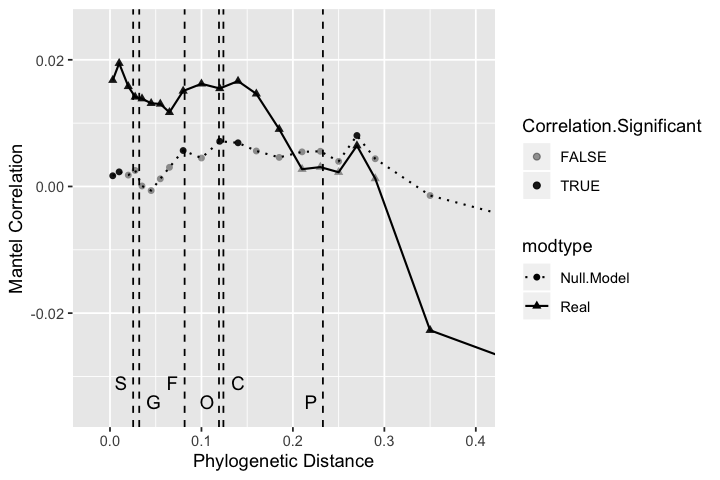

In [46]:
p